In [1]:
import pandas as pd

In [2]:
#importing identified aca posts
posts = pd.read_csv('../data/processed/aca_posts_3.csv')

posts.head()

,Unnamed: 0,selftext,title,time_created,processed_text,processed_title,processed_title_no_stop
0,0,I am 20 years old and looking to get health in...,20 y/o Male. HSA Silver with Kaiser or Covered...,2021-05-10 18:13:16,20 years old looking get health insurance i'm ...,20 year old male hsa silver with kaiser or cov...,20 year old male hsa silver kaiser covered cal...
1,8,I'm transitioning from SSI (which automaticall...,SSDI waiting for medicare. ACA medicaid conflict,2021-05-10 03:02:01,i'm transitioning ssi automatically qualifies ...,ssdi waiting for medicare aca medicaid conflict,ssdi waiting medicare aca medicaid conflict
2,15,Propublica wrote an excellent article on the p...,The dangers of buying non-ACA compliant insura...,2021-05-09 01:22:14,propublica wrote excellent article pitfalls bu...,the dangers of buying non-aca compliant insura...,dangers buying non-aca compliant insurance plans
3,18,* Currently in our special enrollment period a...,Just married! Spouse is a.) *not* eligible for...,2021-05-08 01:45:27,currently special enrollment period wedding on...,just married spouse is a not eligible for aca ...,married spouse eligible aca medicaid b low inc...
4,22,Situation: my children’s mother is an addict. ...,Can you have Medicaid and an ACA plan? Need be...,2021-05-07 21:14:48,situation: children’s mother addict trying get...,can you have medicaid and an aca plan need bet...,medicaid aca plan need better rehab treatment


In [3]:
# how many posts contain which words
len(posts[posts['processed_title'].str.contains('aca')])

346

In [4]:
# how many posts contain which words
len(posts[posts['processed_title'].str.contains('insurance')])

431

In [5]:
len(posts)

1349

In [6]:
#removing insurance
posts['processed_title'] = posts['processed_title'].replace({'insurance': ''}, regex = True)

In [7]:
#pre-processing the text

# Bi and trigrams in the corpus
import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora

texts = posts['processed_title'].values.tolist()

#tokenize words
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) 

text_words = list(sent_to_words(texts))

# Build the bigram and trigram models
bigram = gensim.models.Phrases(text_words, min_count=5, threshold=50) 
trigram = gensim.models.Phrases(bigram[text_words], threshold=100)

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

#functions to make bigram, trigrams, and remove stopwords
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

#call functions and lemmtize text
import spacy
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

text_words_no_stop = remove_stopwords(text_words)

text_bigrams = make_bigrams(text_words_no_stop)
text_trigrams = make_trigrams(text_words_no_stop)

def lemmatization(texts):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc])
    return texts_out

text_lemmatized = lemmatization(text_bigrams)
trigrams_lemmatized = lemmatization(text_trigrams)


#creating corpus and dictionary

#Bigrams
id2word = corpora.Dictionary(text_lemmatized)
full_texts = text_lemmatized
corpus = [id2word.doc2bow(text) for text in full_texts]

#Trigrams
id2word_trigrams = corpora.Dictionary(trigrams_lemmatized)
trigram_texts = trigrams_lemmatized
corpus_trigram = [id2word_trigrams.doc2bow(text) for text in trigram_texts]

In [8]:
import os 
os.environ.update({'MALLET_HOME': r'C:/mallet/mallet-2.0.8',
                    'JAVA_HOME': r'C:/Program Files/Java/jdk-16.0.1'})

mallet_path = 'C:\\mallet\\mallet-2.0.8\\bin\\mallet.bin'

In [10]:
#exploring for bigrams
import gensim.models as modeled

coherence = []

#looping through 2 to 15 topics
for i in range(2,16):
    print('Round: {}'.format(i))

    lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=i, random_state=100, passes=10, per_word_topics=True)  
    cm = gensim.models.coherencemodel.CoherenceModel(model=lda_model, texts=text_lemmatized, dictionary=id2word, coherence='c_v')  
    ch = cm.get_coherence()
    
    # for mallet package
    # lda_model = modeled.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=i, id2word=id2word)

    # coherence_model_ldamallet = CoherenceModel(model=lda_model, texts=text_lemmatized, dictionary=id2word, coherence='c_v')
    # coherence_ldamallet = coherence_model_ldamallet.get_coherence()
                                                
    coherence.append([i,ch])

Round: 2
Round: 3
Round: 4
Round: 5
Round: 6
Round: 7
Round: 8
Round: 9
Round: 10
Round: 11
Round: 12
Round: 13
Round: 14
Round: 15


Text(0.5, 1.0, 'Number of Topics vs Coherence with Bigrams')

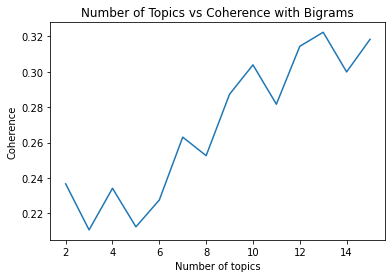

In [14]:
#graph for bigrams
import matplotlib.pyplot as plt

x,y = zip(*coherence)

plt.plot(x,y)
plt.xlabel('Number of topics')
plt.ylabel('Coherence')
plt.title('Number of Topics vs Coherence with Bigrams')

In [15]:
#exploring for trigrams as well

coher_tri = []

for i in range(2,16):
    print('Round: {}'.format(i))

    #lda_model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus_trigram, num_topics=i, id2word=id2word_trigrams)

    #coherence_model_ldamallet = CoherenceModel(model=lda_model, texts=trigrams_lemmatized, dictionary=id2word_trigrams, coherence='c_v')
    #coherence_ldamallet = coherence_model_ldamallet.get_coherence()

    lda_model = gensim.models.LdaMulticore(corpus=corpus_trigram, id2word=id2word_trigrams, num_topics=i, random_state=100, passes=10, per_word_topics=True)  
    cm = gensim.models.coherencemodel.CoherenceModel(model=lda_model, texts=trigrams_lemmatized, dictionary=id2word_trigrams, coherence='c_v')  
    ch = cm.get_coherence()
                                                
    coher_tri.append([i,ch])

Round: 2
Round: 3
Round: 4
Round: 5
Round: 6
Round: 7
Round: 8
Round: 9
Round: 10
Round: 11
Round: 12
Round: 13
Round: 14
Round: 15


Text(0.5, 1.0, 'Number of Topics vs Coherence with Trigrams')

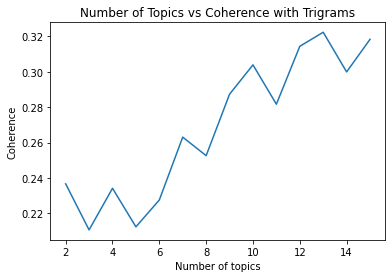

In [16]:
#graph for bigrams
x,y = zip(*coher_tri)

plt.plot(x,y)
plt.xlabel('Number of topics')
plt.ylabel('Coherence')
plt.title('Number of Topics vs Coherence with Trigrams')

In [17]:
# print topics for both trigram and bigram models with 4

lda_model_bigrams = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=4, random_state=100, passes=10, per_word_topics=True)  

lda_model_trigrams = gensim.models.LdaMulticore(corpus=corpus_trigram, id2word=id2word_trigrams, num_topics=4, random_state=100, passes=10, per_word_topics=True)  

In [18]:
lda_model_bigrams.print_topics()

[(0,
  '0.053*"plan" + 0.045*"marketplace" + 0.036*"aca" + 0.026*"premium" + 0.023*"tax_credit" + 0.018*"coverage" + 0.017*"need" + 0.015*"preexisting_condition" + 0.013*"help" + 0.013*"vs"'),
 (1,
  '0.122*"enrollment" + 0.088*"open" + 0.029*"special" + 0.023*"period" + 0.021*"miss" + 0.015*"plan" + 0.013*"question" + 0.012*"option" + 0.012*"help" + 0.012*"outside"'),
 (2,
  '0.058*"marketplace" + 0.026*"aca" + 0.022*"income" + 0.019*"plan" + 0.018*"exchange" + 0.016*"qualify" + 0.016*"question" + 0.016*"healthcare" + 0.016*"state" + 0.012*"medicaid"'),
 (3,
  '0.059*"aca" + 0.044*"marketplace" + 0.039*"get" + 0.028*"plan" + 0.022*"preexisting_condition" + 0.011*"coverage" + 0.010*"question" + 0.009*"job" + 0.009*"health" + 0.008*"tax_credit"')]

In [19]:
lda_model_trigrams.print_topics()

[(0,
  '0.053*"plan" + 0.045*"marketplace" + 0.036*"aca" + 0.026*"premium" + 0.023*"tax_credit" + 0.018*"coverage" + 0.017*"need" + 0.015*"preexisting_condition" + 0.013*"help" + 0.013*"vs"'),
 (1,
  '0.122*"enrollment" + 0.088*"open" + 0.029*"special" + 0.023*"period" + 0.021*"miss" + 0.015*"plan" + 0.013*"question" + 0.012*"option" + 0.012*"help" + 0.012*"outside"'),
 (2,
  '0.058*"marketplace" + 0.026*"aca" + 0.022*"income" + 0.019*"plan" + 0.018*"exchange" + 0.016*"qualify" + 0.016*"question" + 0.016*"healthcare" + 0.016*"state" + 0.012*"medicaid"'),
 (3,
  '0.059*"aca" + 0.044*"marketplace" + 0.039*"get" + 0.028*"plan" + 0.022*"preexisting_condition" + 0.011*"coverage" + 0.010*"question" + 0.009*"job" + 0.009*"health" + 0.008*"tax_credit"')]

In [24]:
lda_model_bigrams_three = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=3, random_state=100, passes=10, per_word_topics=True)  

In [25]:
lda_model_bigrams_three.print_topics()

[(0,
  '0.055*"aca" + 0.050*"plan" + 0.035*"marketplace" + 0.024*"preexisting_condition" + 0.022*"tax_credit" + 0.020*"premium" + 0.018*"coverage" + 0.014*"get" + 0.013*"need" + 0.012*"question"'),
 (1,
  '0.090*"enrollment" + 0.064*"open" + 0.025*"marketplace" + 0.022*"special" + 0.019*"plan" + 0.017*"period" + 0.016*"get" + 0.015*"miss" + 0.014*"aca" + 0.013*"question"'),
 (2,
  '0.061*"marketplace" + 0.029*"aca" + 0.021*"income" + 0.019*"plan" + 0.017*"get" + 0.016*"job" + 0.015*"exchange" + 0.014*"question" + 0.013*"state" + 0.013*"healthcare"')]

In [26]:
## Now applying LDA (4 categories) to our dataset

text_pred = id2word.doc2bow(posts['processed_title_no_stop'][0].split())

In [29]:
lda_model_bigrams.get_document_topics(text_pred)

[(0, 0.30358285), (1, 0.023305133), (2, 0.50106806), (3, 0.17204396)]